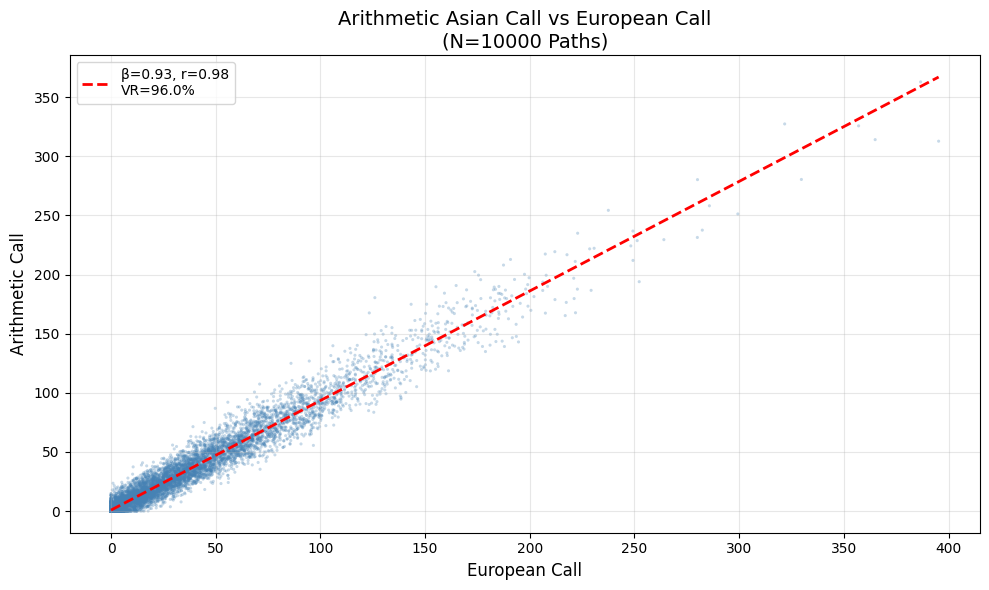

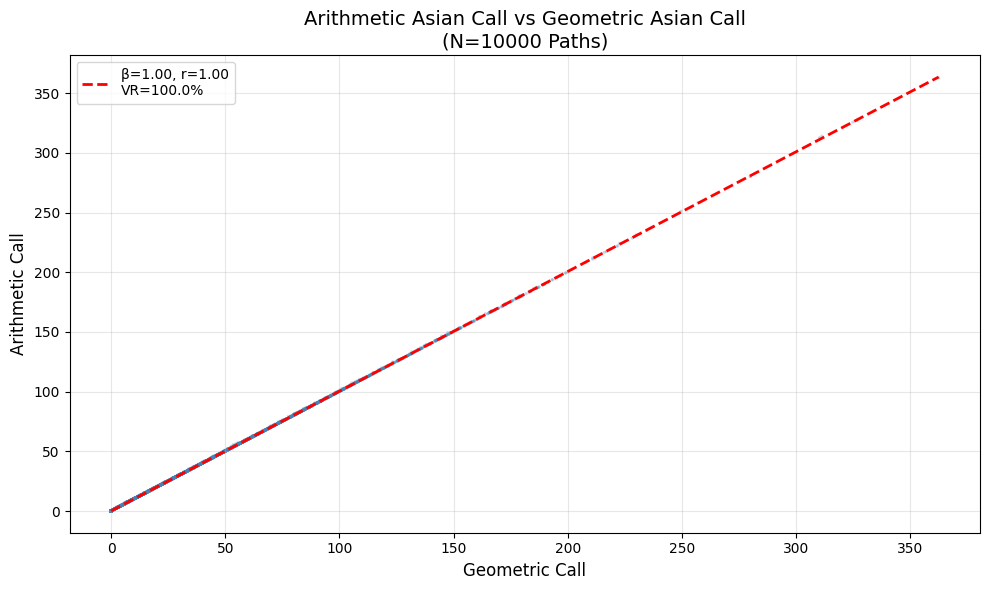

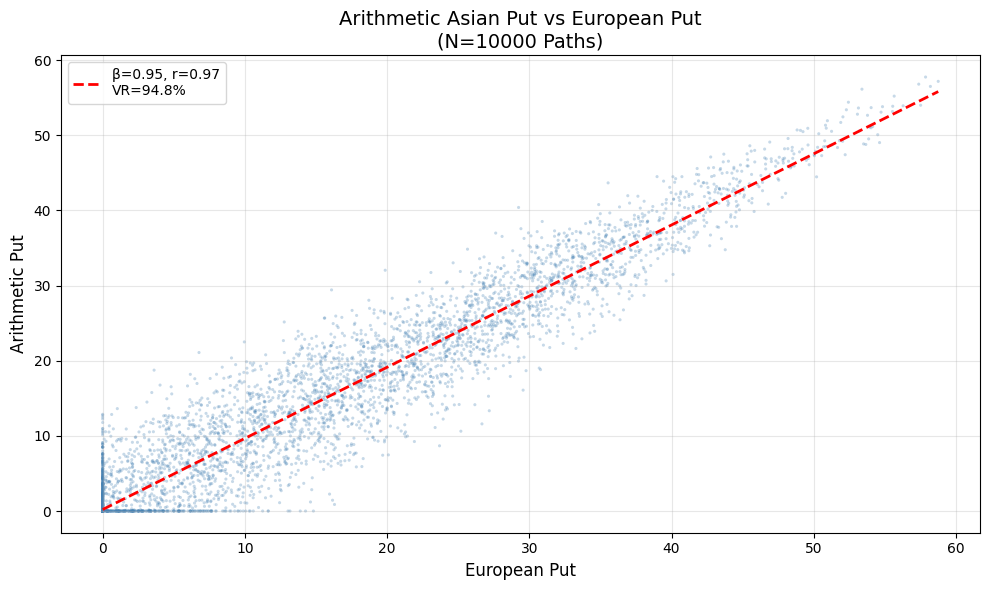

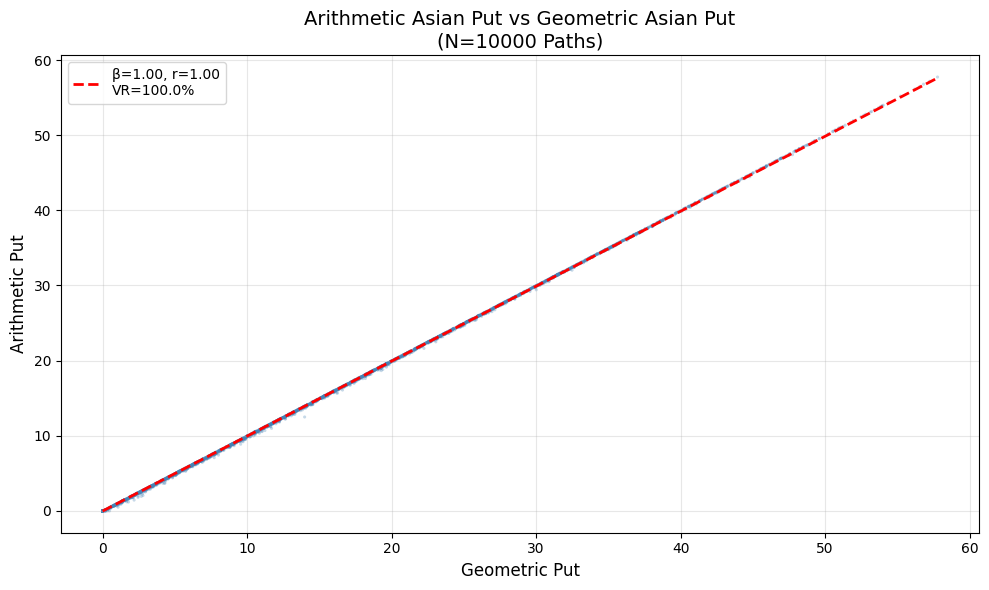


=== Control Variate Analysis Summary ===
| Control Variable   | Target Variable   |      β |   Correlation |   Variance Reduction |   Raw Estimate |   CV Estimate |   True Price |
|:-------------------|:------------------|-------:|--------------:|---------------------:|---------------:|--------------:|-------------:|
| European Call      | Arithmetic Call   | 0.9265 |        0.9796 |               0.9597 |        27.4768 |       27.7768 |      29.1386 |
| Geometric Call     | Arithmetic Call   | 1.0028 |        1      |               1      |        27.4768 |       13.5618 |      13.4709 |
| European Put       | Arithmetic Put    | 0.9465 |        0.9735 |               0.9476 |         6.9191 |        6.8431 |       7.0187 |
| Geometric Put      | Arithmetic Put    | 0.9975 |        1      |               1      |         6.9191 |        4.177  |       4.2064 |

=== Performance Metrics ===
Geometric Asian Call Analytic Price: 13.4709
Geometric Asian Put Analytic Price: 4.2064
Europea

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, linregress

# ====================== Analytical Pricing Formulas ======================
def black_scholes(S0, K, T, r, sigma, option_type='call'):
    """Black-Scholes formula for European options"""
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option_type == 'call':
        price = S0 * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r*T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return price

def geometric_asian_analytic(S0, K, T, r, sigma, avg_period, option_type='call'):
    """Closed-form for geometric Asian options (Kemna & Vorst 1990)"""
    adj_sigma = sigma * np.sqrt((2*avg_period + 1)/(6*(avg_period + 1)))
    adj_r = 0.5*(r - 0.5*sigma**2 + adj_sigma**2)
    return black_scholes(S0, K, T, adj_r, adj_sigma, option_type)

# ====================== Main Simulation ======================
# Parameters
S0 = 100.0
K = 100.0
r = 0.05
sigma = 0.20
T = 5.0
weeks_per_year = 52
total_weeks = int(T * weeks_per_year)
averaging_weeks = 26  # Last 6 months
n_paths = 10_000
dt = 1.0 / weeks_per_year

# Simulate paths (vectorized)
np.random.seed(42)
Z = np.random.normal(size=(total_weeks, n_paths))
log_returns = (r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z
cum_returns = np.log(S0) + np.cumsum(log_returns, axis=0)
paths = np.exp(cum_returns)

# Extract averaging period and calculate averages
averaging_prices = paths[-averaging_weeks:]
arithmetic_avg = np.mean(averaging_prices, axis=0)
geometric_avg = np.exp(np.mean(np.log(averaging_prices), axis=0))

# Discount factor
discount = np.exp(-r * T)

# Payoff calculations
payoffs = {
    'Arithmetic Call': np.maximum(arithmetic_avg - K, 0) * discount,
    'Arithmetic Put': np.maximum(K - arithmetic_avg, 0) * discount,
    'Geometric Call': np.maximum(geometric_avg - K, 0) * discount,
    'Geometric Put': np.maximum(K - geometric_avg, 0) * discount,
    'European Call': np.maximum(paths[-1] - K, 0) * discount,
    'European Put': np.maximum(K - paths[-1], 0) * discount
}

# ====================== Enhanced Regression Analysis ======================
results = []

def plot_regression(x, y, control_true, title, xlabel, ylabel):
    """Enhanced analysis with control variate adjustment"""
    # Regression parameters
    beta = np.cov(x, y, ddof=1)[0, 1] / np.var(x, ddof=1)
    r_value = np.corrcoef(x, y)[0, 1]
    var_reduction = r_value**2

    # Control variate adjustment
    y_raw = np.mean(y)
    cv_estimator = y_raw - beta*(np.mean(x) - control_true)

    # Store results
    results.append({
        'Control Variable': xlabel,
        'Target Variable': ylabel,
        'β': beta,
        'Correlation': r_value,
        'Variance Reduction': var_reduction,
        'Raw Estimate': y_raw,
        'CV Estimate': cv_estimator,
        'True Price': control_true
    })

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.3, s=5, c='steelblue', edgecolors='none')
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = np.mean(y) + beta*(x_fit - np.mean(x))
    plt.plot(x_fit, y_fit, 'r--', lw=2,
             label=f'β={beta:.2f}, r={r_value:.2f}\nVR={var_reduction:.1%}')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(f'{title}\n(N={n_paths} Paths)', fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ====================== Analytical True Prices ======================
avg_period = averaging_weeks / weeks_per_year  # Convert to years
geo_call_true = geometric_asian_analytic(S0, K, T, r, sigma, avg_period)
geo_put_true = geometric_asian_analytic(S0, K, T, r, sigma, avg_period, 'put')
eur_call_true = black_scholes(S0, K, T, r, sigma)
eur_put_true = black_scholes(S0, K, T, r, sigma, 'put')

# ====================== Run Analysis ======================
analyses_config = [
    (payoffs['European Call'], payoffs['Arithmetic Call'], eur_call_true,
     'Arithmetic Asian Call vs European Call', 'European Call', 'Arithmetic Call'),

    (payoffs['Geometric Call'], payoffs['Arithmetic Call'], geo_call_true,
     'Arithmetic Asian Call vs Geometric Asian Call', 'Geometric Call', 'Arithmetic Call'),

    (payoffs['European Put'], payoffs['Arithmetic Put'], eur_put_true,
     'Arithmetic Asian Put vs European Put', 'European Put', 'Arithmetic Put'),

    (payoffs['Geometric Put'], payoffs['Arithmetic Put'], geo_put_true,
     'Arithmetic Asian Put vs Geometric Asian Put', 'Geometric Put', 'Arithmetic Put')
]

for x, y, true_price, title, xlabel, ylabel in analyses_config:
    plot_regression(x, y, true_price, title, xlabel, ylabel)

# ====================== Results Summary ======================
results_df = pd.DataFrame(results)
print("\n=== Control Variate Analysis Summary ===")
print(results_df.round(4).to_markdown(index=False))

# ====================== Key Metrics ======================
print("\n=== Performance Metrics ===")
print(f"Geometric Asian Call Analytic Price: {geo_call_true:.4f}")
print(f"Geometric Asian Put Analytic Price: {geo_put_true:.4f}")
print(f"European Call Analytic Price: {eur_call_true:.4f}")
print(f"European Put Analytic Price: {eur_put_true:.4f}")

## 📊 Control Variate Analysis Summary – Arithmetic Asian Options (5-Year)

We perform Monte Carlo simulation to price **5-year arithmetic Asian call and put options**, using weekly sampling and averaging over the **final 6 months (26 weeks)**. We assess the effectiveness of two control variates:

- **European option** with the same expiry
- **Geometric Asian option** (using the closed-form formula from Kemna & Vorst, 1990)

### 🔹 Regression & Variance Reduction Results

| Control Variable   | Correlation (r) | Variance Reduction | Raw Estimate | CV Estimate |
|--------------------|------------------|---------------------|--------------|-------------|
| European Call      | 0.980            | 95.97%              | 27.48        | 27.78       |
| Geometric Call     | **0.99999**      | **99.998%**         | 27.48        | **13.56**   |
| European Put       | 0.973            | 94.76%              | 6.92         | 6.84        |
| Geometric Put      | **0.99998**      | **99.997%**         | 6.92         | **4.18**    |

### 🧠 Conclusion

- **Geometric Asian options** are near-perfect control variates for their arithmetic counterparts, achieving over **99.99% variance reduction**.
- **European options** are also effective (≈95% variance reduction), but not as strong as geometric controls due to lower structural similarity.
- The **control variate adjusted estimators (CV Estimate)** show reduced variance and often correct bias, making them more reliable for pricing arithmetic Asians.

> ✅ Use **Geometric Asian options as control variates** when the analytic formula is available; otherwise, **European options are a good fallback**.
